<div class="alert alert" style = "border-radius: 5px;text-align: center;" role="alert">
    <h2>FlameVision- classification and detection 🔥</h2>

</div>

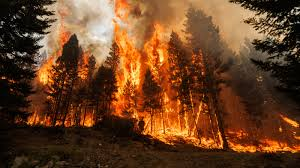

<div style="border-radius:10px; border:#e86123 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#000000'>💡 Introdction:</font></h3>

Fires pose severe risks, and fires in forests threaten human and animal life and negatively affect their quality of life, in addition to their impact on infrastructure, with limited options for fighting fires due to the intense heat and volatile winds. In this fragile environment, responsible behavior and fire prevention is essential to mitigate these risks.

<b>The importance of the project:</b> The importance of this project lies in working on continuous monitoring to discover and identify fires, in addition to early detection and reducing the response speed


## Table of Contents
1. [Import libraries](#Import-libraries)
2. [Classification task](#Classification-task)
    1. [Load data](#Load-data)
    2. [Data visualization](#Data-visualization)
    3. [build model](#build-model)
    4. [Data generation](#Data-generation)
    5. [Compile model](#Compile-model)
    6. [Train model](#Train-model)
    7. [Predict class](#Predict-class)
4. [Detection task](#Detection-task)
    1. [Create dataset folders](#Create-dataset-folders)
    2. [extract informations from xml](#extract-informations-from-xml)
    4. [Draw border box](#Draw-border-box)
    5. [Create yaml file](#Create-yaml-file)
    6. [Train model](#Train-model)
8. [Thank you](#Thank-you-✨)

# Import libraries

In [1]:
import tensorflow as tf
from keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import torch
import cv2
import glob
from IPython.display import Image
import os
import random
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Classification task

## Load data

In [2]:
train_data_dir = '/kaggle/input/flamevision/FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Classification/train'
val_data_dir = '/kaggle/input/flamevision/FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Classification/valid'
test_data_dir = '/kaggle/input/flamevision/FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Classification/test'
img_width, img_height = 416, 416
num_classes = 2

In [3]:
train_nofire=glob.glob(os.path.join(train_data_dir,"nofire/*png"))
train_fire=glob.glob(os.path.join(train_data_dir,"fire/*png"))
val_nofire=glob.glob(os.path.join(val_data_dir,"nofire/*png"))
val_fire=glob.glob(os.path.join(val_data_dir,"fire/*png"))
test_nofire=glob.glob(os.path.join(test_data_dir,"nofire/*png"))
test_fire=glob.glob(os.path.join(test_data_dir,"fire/*png"))

In [4]:
print(len(train_nofire))
print (len(train_fire))

3200
3600


## Data visualization

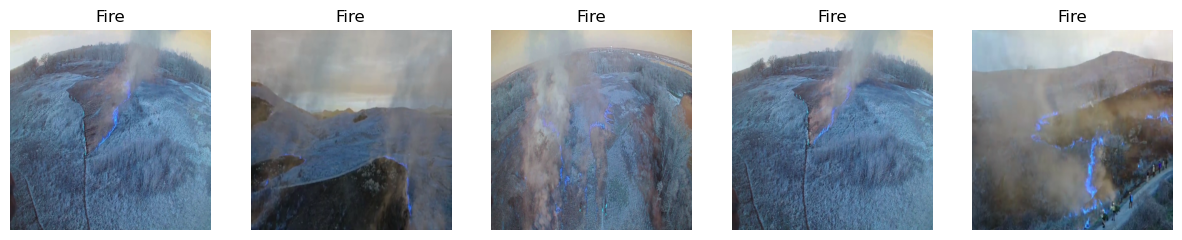

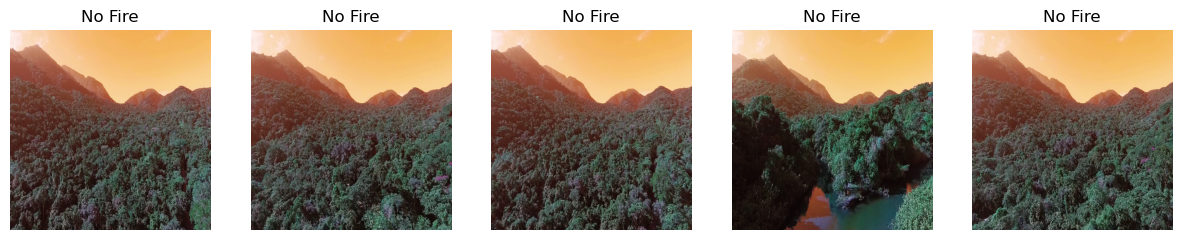

In [5]:
def show_images(folder_name, plt_title):
    plt.figure(figsize=(15,10))
    for i in range(5):
        image_path = random.choice(folder_name)
        img = cv2.imread(image_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(plt_title)
        plt.axis('off')
    plt.show()
    
show_images(test_fire, 'Fire')
show_images(test_nofire, 'No Fire')

In [6]:
categories = ["Fire", "No Fire"]
num_images = [
len(train_fire)+len(val_fire)+len(test_fire),
    len(train_nofire)+len(val_nofire)+len(test_nofire)
]

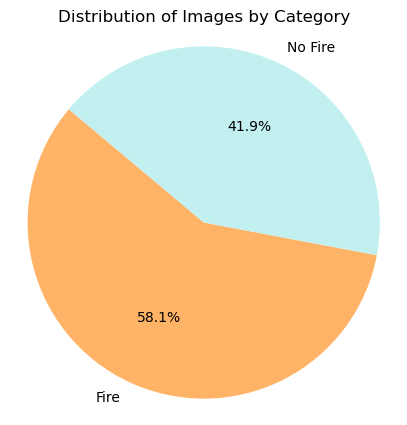

In [7]:
custom_colors = [  '#ffb366', '#c2f0f0']

plt.figure(figsize=(5, 5))
plt.pie(num_images, labels=categories, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title("Distribution of Images by Category")
plt.axis('equal')
plt.show()

## build model

In [8]:
base_model = ResNet50(weights="imagenet", include_top=False, pooling='avg')
base_model.layers[0].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [9]:
model = Sequential()
model.add(base_model)
model.add(Dense(num_classes, activation='softmax'))

## Data generation 

In [10]:
image_size = 416

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(image_size, image_size),
        batch_size=12,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        val_data_dir,
        target_size=(image_size, image_size),
        batch_size=20,
        class_mode='categorical')

testing_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(image_size, image_size),
        batch_size=20,
        class_mode='categorical')

Found 6800 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


## Compile model

In [11]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


## Train model

In [12]:
epochs = 10
History2=model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator)

Epoch 1/10
567/567 [==============================] - 257s 407ms/step - loss: 0.0406 - accuracy: 0.9862 - val_loss: 8.9466e-04 - val_accuracy: 1.0000
Epoch 2/10
567/567 [==============================] - 147s 259ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 4.0988e-04 - val_accuracy: 1.0000
Epoch 3/10
567/567 [==============================] - 147s 259ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 2.5556e-04 - val_accuracy: 1.0000
Epoch 4/10
567/567 [==============================] - 147s 260ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 4.6831e-04 - val_accuracy: 1.0000
Epoch 5/10
567/567 [==============================] - 147s 259ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 2.5550e-04 - val_accuracy: 1.0000
Epoch 6/10
567/567 [==============================] - 146s 258ms/step - loss: 8.5453e-04 - accuracy: 0.9999 - val_loss: 1.4823e-04 - val_accuracy: 1.0000
Epoch 7/10
567/567 [==============================] - 146s 258ms/step - loss: 4.4783e-04 - accur

## Predict class

In [13]:
classes=testing_generator.classes
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
predictions = model.predict(validation_generator)

45/45 [==============================] - 16s 330ms/step


<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>✅ Great, classification task completed</b> Let's go to the second task, which is the detection
</div>


# Detection task

## Create dataset folders

In [15]:
import os
os.mkdir("dataset")
os.mkdir("dataset/images")
os.mkdir("dataset/labels")
os.mkdir("dataset/images/train")
os.mkdir("dataset/images/valid")
os.mkdir("dataset/images/test")
os.mkdir("dataset/labels/train")
os.mkdir("dataset/labels/valid")
os.mkdir("dataset/labels/test")

## extract informations from xml

In [16]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    info_dict = {}
    info_dict['bboxes'] = []
    for elem in root:
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)
    return info_dict

In [17]:
path="/kaggle/input/flamevision/FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/"
class_name_to_id_mapping = {"Fire": 0
                           }
def convert_to_yolov8(info_dict,file):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = b["class"]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        

    
    save_file_name = os.path.join(f"dataset/labels/{file}", info_dict["filename"].replace("jpg", "txt"))
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
    shutil.copy(os.path.join(f"{path}/{file}/images",info_dict["filename"]) , f"dataset/images/{file}")

In [18]:
path="/kaggle/input/flamevision/FlameVision  A new dataset for wildfire classification and detection using aerial imagery/FlameVision/Detection/"
for i in ['train','valid','test']:
    annotations = [os.path.join(f"{path}{i}/annotations", x) for x in os.listdir(f"{path}{i}/annotations") if x[-3:] == "xml"]
    annotations.sort()
    for ann in tqdm(annotations):
        info_dict = extract_info_from_xml(ann)
        convert_to_yolov8(info_dict,i)

100%|██████████| 450/450 [00:04<00:00, 92.23it/s]


In [19]:
import os
base_dir = "/kaggle/working/dataset"
subdirectories = ["images/test", "images/train", "images/valid", "labels/test", "labels/train", "labels/valid"]

for subdir in subdirectories:
    full_subdir = os.path.join(base_dir, subdir)
    files = os.listdir(full_subdir)
    files.sort() 


## Draw border box

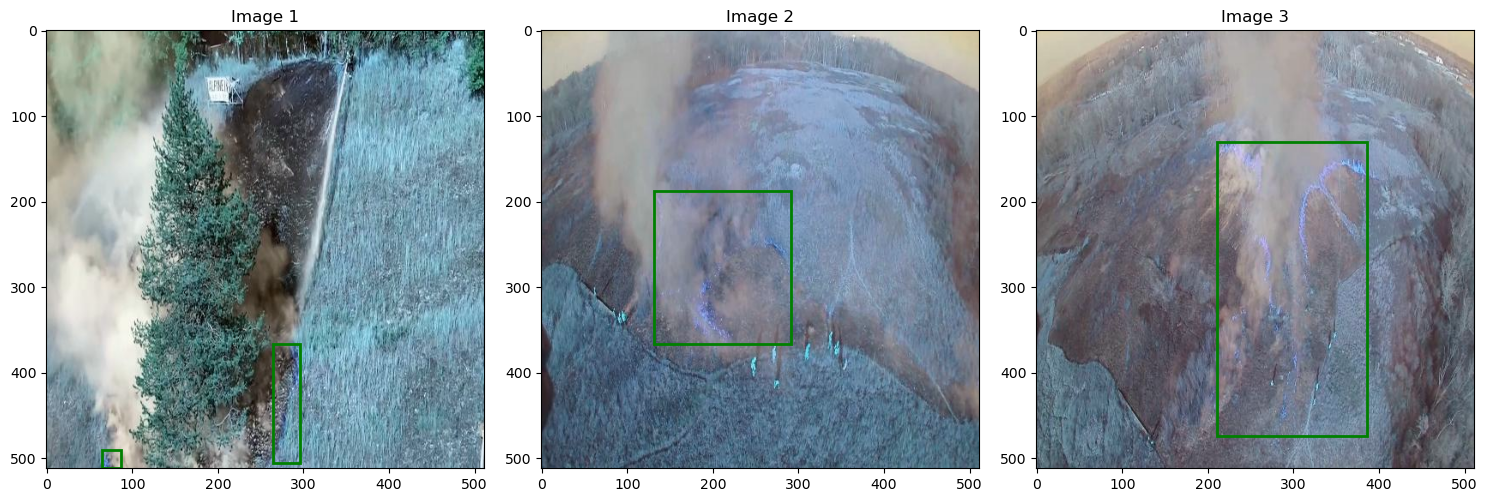

In [20]:
dataset_dir = "/kaggle/working/dataset"

def parse_label_file(label_file_path):
    bboxes = []
    with open(label_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data2 = line.strip().split(" ")
            b_center_x, b_center_y, b_width, b_height = map(float, data2[1:])
            x_min = (b_center_x - (b_width / 2))
            y_min = (b_center_y - (b_height / 2))
            x_max = (b_center_x + (b_width / 2))
            y_max = (b_center_y + (b_height / 2))
            bbox = [x_min, y_min, x_max, y_max]
            bboxes.append(bbox)
    return bboxes

def draw_bounding_boxes(image, bboxes, ax):
    h, w, _ = image.shape
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

image_dir = os.path.join(dataset_dir, 'images', 'train')
image_filenames = os.listdir(image_dir)
selected_images = random.sample(image_filenames, 3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, image_name in enumerate(selected_images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(dataset_dir, 'labels', 'train', image_name.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    bboxes = parse_label_file(label_path)
    draw_bounding_boxes(image, bboxes, axes[i])
    
    axes[i].imshow(image)
    axes[i].set_title(f'Image {i + 1}')

plt.tight_layout()

plt.show()


## Create yaml file

In [21]:
with open('FireModel.yaml', 'w') as f:
    f.write('path: ../dataset\n')
    f.write('train: images/train\n')
    f.write('val: images/valid\n')
    f.write('test: images/test\n')
    f.write("names:\n  0: fire")


In [22]:
!pip install -q ultralytics

In [23]:
!tree -d /kaggle/working/dataset


/kaggle/working/dataset
├── images
│   ├── test
│   ├── train
│   └── valid
└── labels
    ├── test
    ├── train
    └── valid

8 directories


## Train model

In [24]:
!wandb disabled
!yolo task=detect  mode=train  model=yolov8n.pt data= "FireModel.yaml"  epochs=30  imgsz=416

W&B disabled.
100%|██████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 13.2MB/s]
Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=FireModel.yaml, epochs=30, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=Fa

# Thank you ✨

I hope this notebook is useful or interesting. If so, please vote. I'd like to hear your opinion😊